In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('../2023/seminar-12-time-series/ds_dahab/ds_dahab/wind_data_dahab.csv')
data.index = pd.to_datetime(data['timestamp'], unit='s')

data.drop(['meteostationID', 'timestamp',
           'temperature', 'pressure',
           'humidity'], axis=1, inplace=True)

In [8]:
data_november = data.truncate(before='2018-11-01', after='2018-11-30')
data_november = data_november[['wind_avg_ms']]

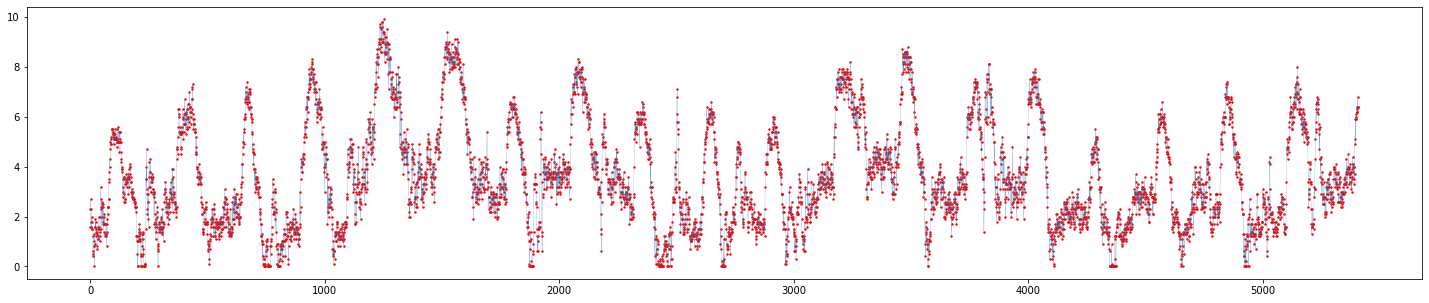

In [9]:
x = data_november['wind_avg_ms']
plt.figure(figsize=(25,5))
plt.plot(np.arange(len(x)), x, lw=0.2)
plt.scatter(np.arange(len(x)), x, s=2, c='r');

In [6]:
from sklearn.linear_model import LinearRegression

# Data frequency (minutes vs days...)

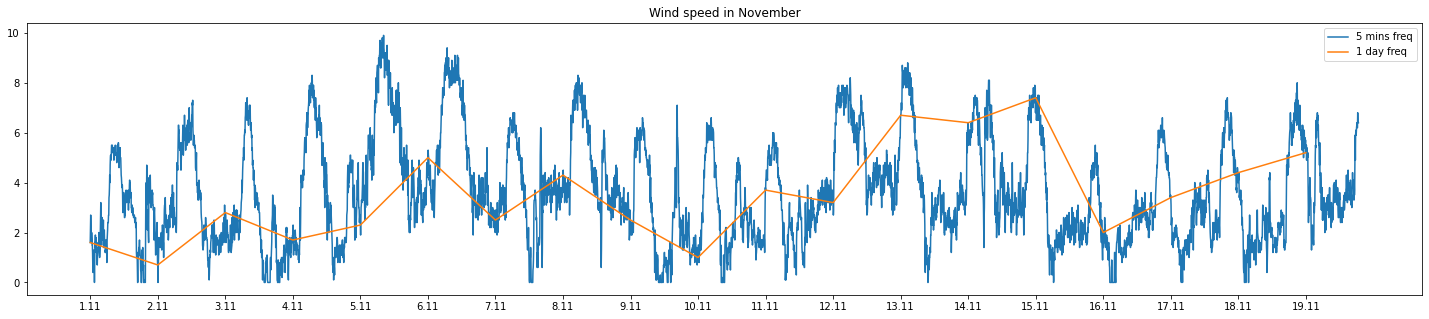

In [12]:
ticks = [f'{dt.day}.{dt.month}' for dt in data_november.index[0:-1:288]]

plt.figure(figsize=(25,5))
plt.plot(range(0, data_november.shape[0]), data_november['wind_avg_ms'], label='5 mins freq')
plt.plot(range(0, data_november.shape[0], 288), data_november['wind_avg_ms'].iloc[0:-1:288], label='1 day freq')
plt.xticks(range(0, data_november.shape[0], 288), ticks)
plt.legend()
plt.title('Wind speed in November');

# Train, validation, test

Time-based split, o/w you are risking using "future" to predict "past", which is not viable in production scenario.

In [13]:
data_train = data_november.truncate(after='2018-11-16')
data_val = data_november.truncate(before='2018-11-16', after='2018-11-18')
data_test = data_november.truncate(before='2018-11-18')

In [15]:
data_train.head()

,wind_avg_ms
timestamp,
2018-11-01 00:04:58,1.6
2018-11-01 00:10:06,2.3
2018-11-01 00:15:15,2.7
2018-11-01 00:20:24,2.3
2018-11-01 00:25:32,1.8


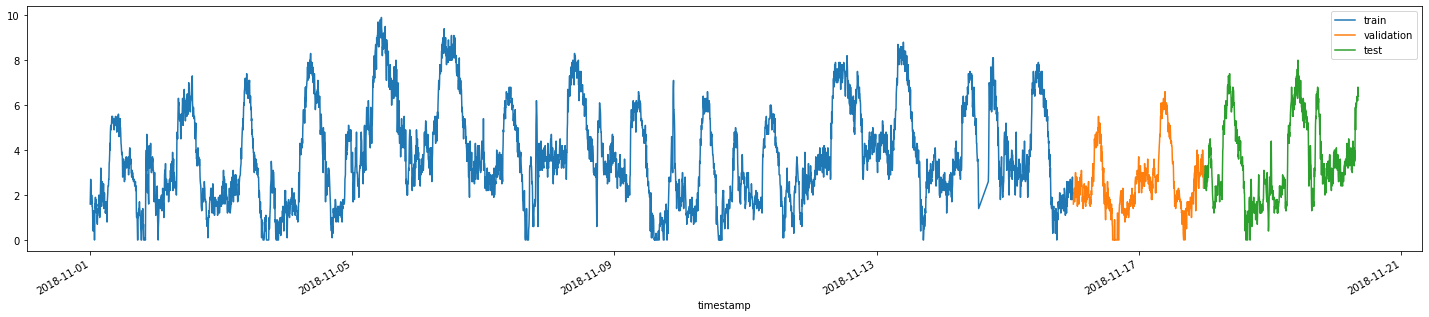

In [14]:
fig = plt.figure(figsize=(25,5))
data_train['wind_avg_ms'].plot(figure=fig, label='train')
data_val['wind_avg_ms'].plot(figure=fig, label='validation')
data_test['wind_avg_ms'].plot(figure=fig, label='test')
plt.legend();

In [ ]:
ARMA, ARIMA

Auto Regression Moving Average ARMA

# How to predict future?

1. Predict $K$ tacts into the future:
- **+** easier to setup, lesser risk of overfitting
- **--** most recent information is not available for the model
2. Predict $1$ tact into the future. In order to predict $K$ tacts we predict first tact, use this prediction for imputation, use the same model to predict second tact, etc.
- **+** most recent information is available at training
- **--** harder to setup, higher risk of overfitting, model errors' accumulation



## $K$ is task specific

we will use K=12

## How to generate features?

Mostly using various lags, and their transformations

In [31]:
X = data_train.copy()
for i in range(1, 24):
    X['lag_{}'.format(i)] = data_train.shift(i)

In [32]:
import datetime

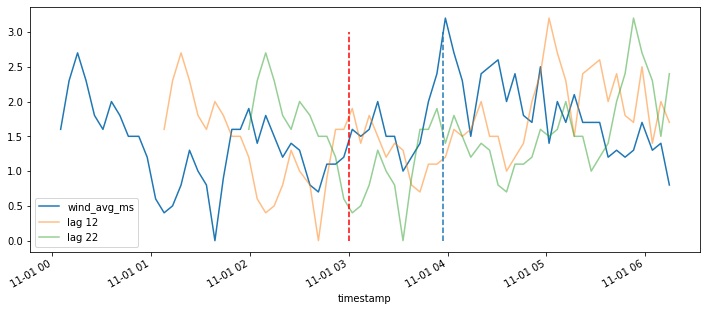

In [33]:
plt.figure(figsize=(12,5))
X.iloc[:72]['wind_avg_ms'].plot(label='wind_avg_ms')
X.iloc[:72]['lag_12'].plot(label='lag 12', alpha=0.5)
X.iloc[:72]['lag_22'].plot(label='lag 22', alpha=0.5)
plt.vlines(datetime.datetime(year=2018, month=11, day=1, hour=3, minute=0),
            0, 3, color='r', ls='--')
plt.vlines(datetime.datetime(year=2018, month=11, day=1, hour=3, minute=57),
            0, 3, ls='--')
plt.legend();

In [47]:
# X.loc['2018-11-01 00:57:32']
X[['wind_avg_ms', 'lag_1', 'lag_10']].iloc[9:25]

,wind_avg_ms,lag_1,lag_10
timestamp,,,
2018-11-01 00:52:27,1.5,1.5,NaN
2018-11-01 00:57:32,1.2,1.5,1.6
2018-11-01 01:02:40,0.6,1.2,2.3
2018-11-01 01:07:49,0.4,0.6,2.7
2018-11-01 01:12:57,0.5,0.4,2.3
2018-11-01 01:18:06,0.8,0.5,1.8
2018-11-01 01:23:14,1.3,0.8,1.6
2018-11-01 01:28:23,1.0,1.3,2.0
2018-11-01 01:33:31,0.8,1.0,1.8


In [36]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

In [37]:
def generate_autoregressive_simple(x):
        
    X = pd.DataFrame(index=x.index)
    for i in range(12, 24):
        X['lag_{}'.format(i)] = x.shift(i)
    X['y'] = x['wind_avg_ms']
    return X

In [38]:
train = generate_autoregressive_simple(data_train)

In [40]:
train.iloc[:14]

,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,y
timestamp,,,,,,,,,,,,,
2018-11-01 00:04:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6
2018-11-01 00:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3
2018-11-01 00:15:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.7
2018-11-01 00:20:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3
2018-11-01 00:25:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8
2018-11-01 00:30:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6
2018-11-01 00:35:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2018-11-01 00:40:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8
2018-11-01 00:46:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


In [41]:
train = train.dropna()

In [83]:
model_ridge = Ridge()
model_lasso = Lasso()
model_tree = DecisionTreeRegressor(max_depth=20, min_samples_leaf=10)

model_ridge.fit(train.drop('y', axis=1), train['y'])
model_lasso.fit(train.drop('y', axis=1), train['y'])
model_tree.fit(train.drop('y', axis=1), train['y']);

In [84]:
y_pred_ridge = model_ridge.predict(train.drop('y', axis=1))
y_pred_lasso = model_lasso.predict(train.drop('y', axis=1))
y_pred_tree = model_tree.predict(train.drop('y', axis=1))

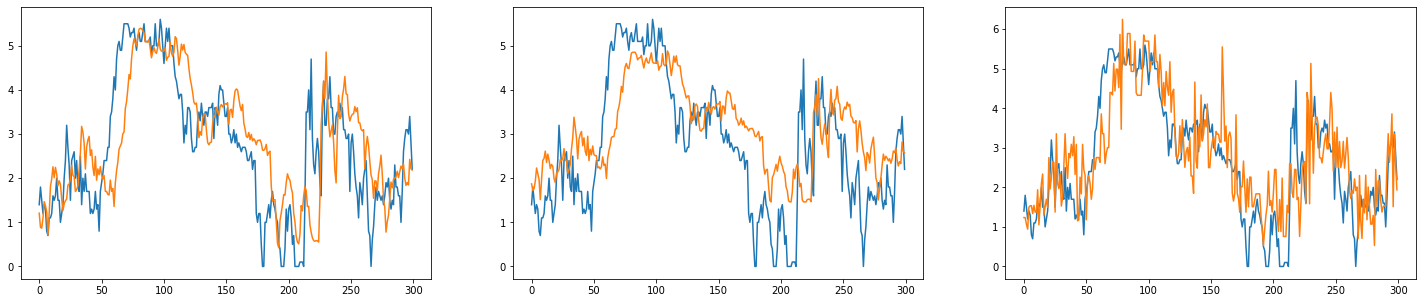

In [85]:
fig, axs = plt.subplots(1, 3, figsize=(25,5))

axs[0].plot(train['y'].values[:300])
axs[1].plot(train['y'].values[:300])
axs[2].plot(train['y'].values[:300])


axs[0].plot(y_pred_ridge[:300])
axs[1].plot(y_pred_lasso[:300])
axs[2].plot(y_pred_tree[:300]);

In [86]:
from sklearn.metrics import mean_absolute_error as mae

In [87]:
mae(train['y'], y_pred_ridge)

0.899310823175746

In [88]:
mae(train['y'], y_pred_lasso)

1.026214437475104

In [89]:
mae(train['y'], y_pred_tree)

0.6987765296872661

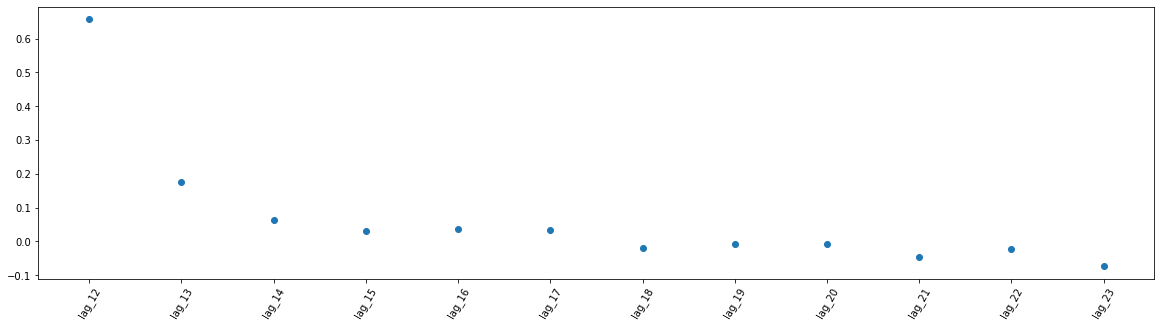

In [90]:
plt.figure(figsize=(20,5))
plt.scatter(range(len(model_ridge.coef_)), model_ridge.coef_)
plt.xticks(range(len(model_ridge.coef_)),train.drop('y', axis=1).columns, rotation=60);

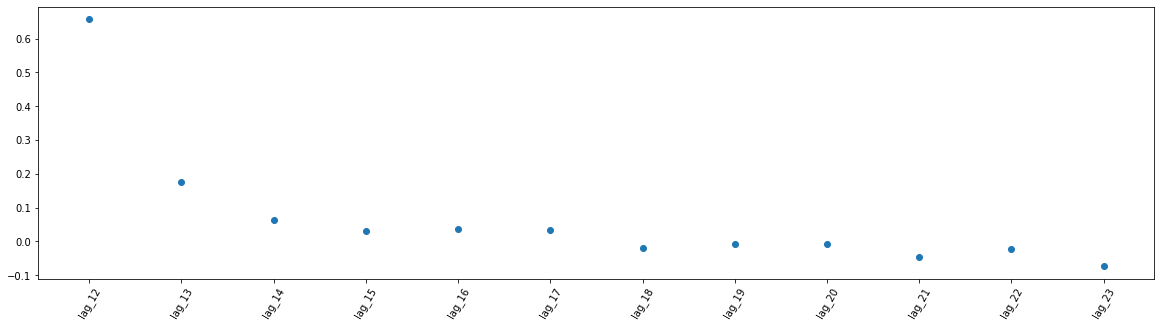

In [91]:
plt.figure(figsize=(20,5))
plt.scatter(range(len(model_lasso.coef_)), model_ridge.coef_)
plt.xticks(range(len(model_lasso.coef_)),train.drop('y', axis=1).columns, rotation=60);

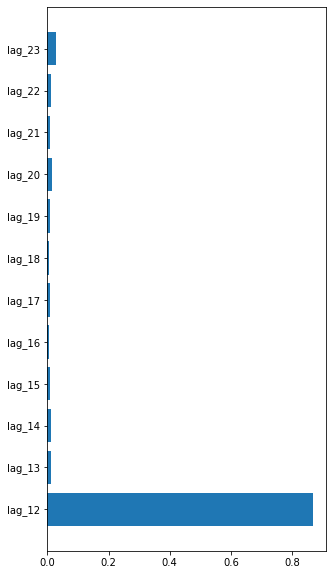

In [92]:
plt.figure(figsize=(5,10))
plt.barh(range(train.drop('y', axis=1).columns.shape[0]), model_tree.feature_importances_,)
plt.yticks(range(train.drop('y', axis=1).columns.shape[0]), train.drop('y', axis=1).columns);

In [93]:
def stack_data_for_feature_generation(data_train, data_val, n_prior_rows=12):
    return pd.concat([data_train.iloc[-n_prior_rows:], data_val], )

In [95]:
# First `n_prior_rows` are for feature generation. 
# Do not forget to drop them after feature generation is done

n_prior_rows = 24
data_val_stacked = stack_data_for_feature_generation(data_train, data_val, n_prior_rows=n_prior_rows)

In [105]:
val = generate_autoregressive_simple(data_val_stacked)
val = val[n_prior_rows:]

In [106]:
y_pred_val = model_tree.predict(val.drop('y',  axis=1),)

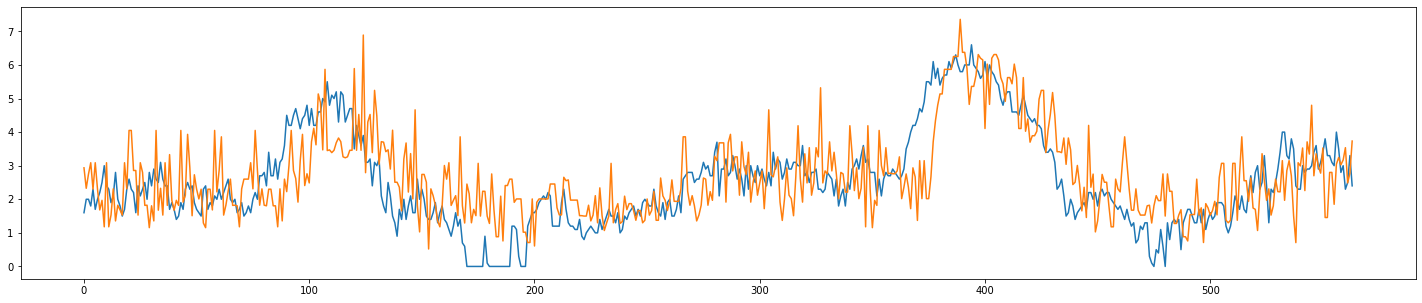

In [107]:
plt.figure(figsize=(25,5))
plt.plot(val['y'].values)
plt.plot(y_pred_val);

# plt.plot(val['y'].values - y_pred_val)

In [108]:
from sklearn.metrics import mean_absolute_error

In [109]:
mean_absolute_error(val['y'].values, y_pred_val)

0.864879679462752

In [110]:
val['y'].mean()

2.530141843971631

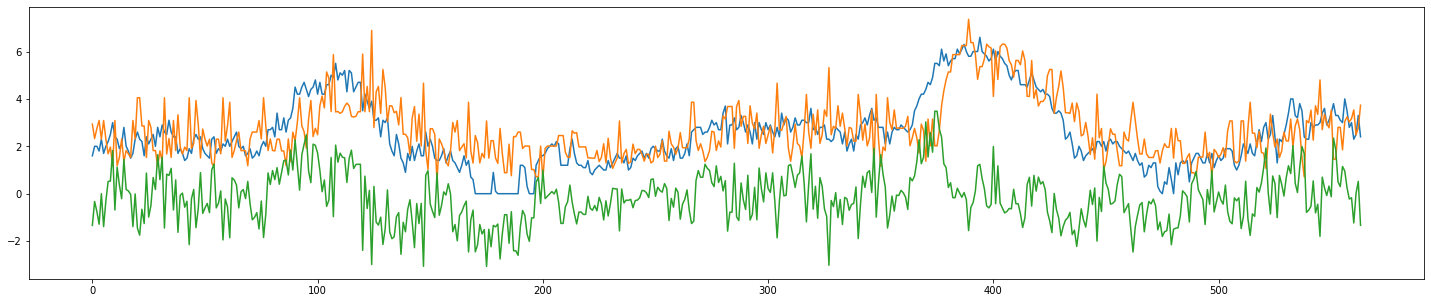

In [113]:
plt.figure(figsize=(25,5))
plt.plot(val['y'].values)
plt.plot(y_pred_val);

plt.plot(val['y'].values - y_pred_val);

In [117]:
# from scipy.stats import normaltest

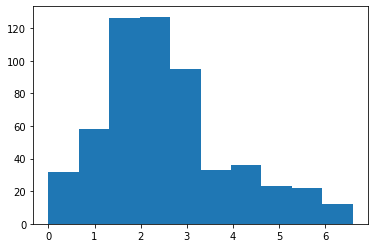

In [115]:
plt.hist(val['y'].values);

## Let's check distribution of the residuals

In [118]:
from scipy.stats import normaltest

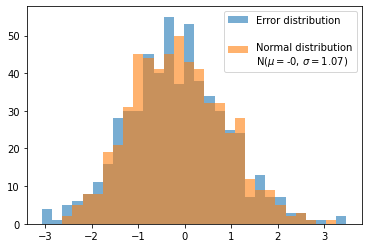

In [119]:
error = val['y'].values - y_pred_val
normal = np.random.normal(loc=error.mean(),
                          scale=error.std(),
                          size=error.shape[0])

bins = plt.hist(error, bins=30, alpha=0.6, label='Error distribution');

plt.hist(normal, bins=bins[1], alpha=.6,
         label='\nNormal distribution\nN($\mu =${:.0f}, $\sigma =${:.2f})'.format(error.mean(), error.std()));

plt.legend();

In [120]:
normaltest(error)

NormaltestResult(statistic=4.190559371280536, pvalue=0.12303582748715161)

In [121]:
error = val['y'].values

In [122]:
normaltest(error)

NormaltestResult(statistic=42.473849420865314, pvalue=5.983024560863146e-10)

# What else?

In [123]:
def lin_reg(X):
    n = X.shape[0]
    x = np.concatenate((np.ones(n),
                        np.arange(n)),
                      ).reshape(2, n).T
    
    y = X.reshape(-1,1)
    theta = np.linalg.pinv(x.dot(x.T)).dot(x).T.dot(y)

    return np.array([[1, n]]).dot(theta)

In [124]:
12*24

288

In [125]:
def generate_autoregressive(x):
        
    X = pd.DataFrame(index=x.index)
    for i in range(12, 24):
        X['lag_{}'.format(i)] = x.shift(i)
        
    for i in range(12*24, 12*25):
        X['lag_{}'.format(i)] = x.shift(i)
    
    X['lin_reg_12_3'] = x.shift(12).rolling(window=3).apply(lin_reg, raw=True)
    X['lin_reg_12_5'] = x.shift(12).rolling(window=5).apply(lin_reg, raw=True)
    X['lin_reg_12_12'] = x.shift(12).rolling(window=12).apply(lin_reg, raw=True)
    
    X['mean_shift_12_3'] = x.shift(12).rolling(window=3).mean()
    X['mean_shift_12_5'] = x.shift(12).rolling(window=5).mean()
    X['mean_shift_12_12'] = x.shift(12).rolling(window=12).mean()
    
    # 288 = 12 * 24
    X['lin_reg_288_3'] = x.shift(288).rolling(window=3).apply(lin_reg, raw=True)
    X['lin_reg_288_5'] = x.shift(288).rolling(window=5).apply(lin_reg, raw=True)
    X['lin_reg_288_12'] = x.shift(288).rolling(window=12).apply(lin_reg, raw=True)
    
    X['mean_shift_288_3'] = x.shift(288).rolling(window=3).mean()
    X['mean_shift_288_5'] = x.shift(288).rolling(window=5).mean()
    X['mean_shift_288_12'] = x.shift(288).rolling(window=12).mean()
    
    
    shifts = [12, 24, 36, 48]
    window_size = ...
    for shift in shifts:
        for wind
    
    X['y'] = x['wind_avg_ms']
    return X

In [127]:
import numpy as np

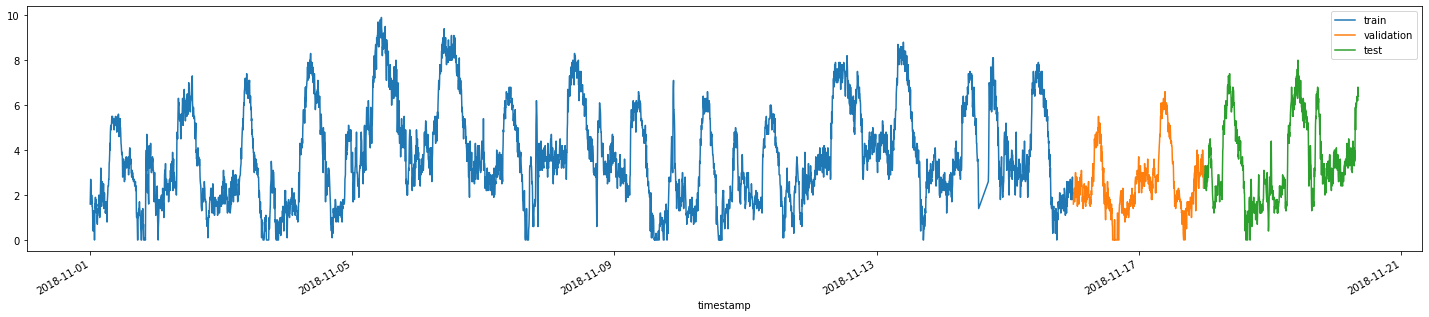

In [126]:
fig = plt.figure(figsize=(25,5))
data_train['wind_avg_ms'].plot(figure=fig, label='train')
data_val['wind_avg_ms'].plot(figure=fig, label='validation')
data_test['wind_avg_ms'].plot(figure=fig, label='test')
plt.legend();

In [128]:
from sklearn.ensemble import RandomForestRegressor

In [129]:
train = generate_autoregressive_simple(data_train)

train = train.dropna()

In [130]:
rf = RandomForestRegressor()
rf.fit(train.drop('y', axis=1), train['y'])

RandomForestRegressor()

In [131]:
n_prior_rows = 24
data_val_stacked = stack_data_for_feature_generation(data_train, data_val, n_prior_rows=n_prior_rows)
val = generate_autoregressive_simple(data_val_stacked)
val = val[n_prior_rows:]

In [132]:
y_pred_val = rf.predict(val.drop('y', axis=1))

In [133]:
mean_absolute_error(val['y'], y_pred_val)

0.7200212765957447

In [135]:
# train
train = generate_autoregressive(data_train)
train = train.dropna()

# val
n_prior_rows = 288+12
data_val_stacked = stack_data_for_feature_generation(data_train, data_val, n_prior_rows=n_prior_rows)
val = generate_autoregressive(data_val_stacked)
val = val[n_prior_rows:]

# test
n_prior_rows = 288+12
data_test_stacked = stack_data_for_feature_generation(data_val, data_test, n_prior_rows=n_prior_rows)
test = generate_autoregressive(data_test_stacked)
test = test[n_prior_rows:]

In [136]:
rf = RandomForestRegressor()
rf.fit(train.drop('y', axis=1), train['y'])

RandomForestRegressor()

In [137]:
y_pred_val = rf.predict(val.drop('y', axis=1))

In [138]:
mean_absolute_error(val['y'], y_pred_val)

0.6730904255319148

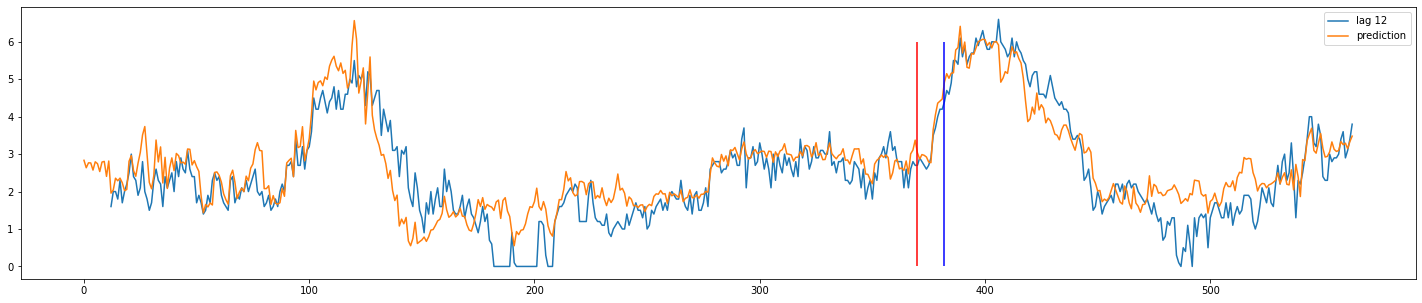

In [150]:
plt.figure(figsize=(25,5))
# plt.plot(range(val['y'].values.shape[0]), val['y'].values, label='X')
plt.plot(range(12, val['y'].values.shape[0]), val['y'].values[:-12], label='lag 12')
plt.plot(range(val['y'].values.shape[0]), y_pred_val, label='prediction');
plt.vlines([370], 0, 6, color='r')
plt.vlines([382], 0, 6, color='b')
plt.legend()

# plt.plot(val['y'].values - y_pred_val);

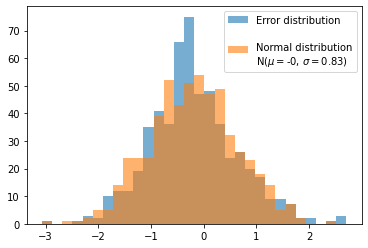

In [140]:
error = val['y'].values - y_pred_val
normal = np.random.normal(loc=error.mean(),
                          scale=error.std(),
                          size=error.shape[0])

bins = plt.hist(error, bins=30, alpha=0.6, label='Error distribution');

plt.hist(normal, bins=bins[1], alpha=.6,
         label='\nNormal distribution\nN($\mu =${:.0f}, $\sigma =${:.2f})'.format(error.mean(), error.std()));

plt.legend();

In [151]:
from catboost import CatBoostRegressor
model = CatBoostRegressor()

# Fit model
model.fit(train.drop('y', axis=1), train['y'])
# Get predictions
preds = model.predict(val.drop('y', axis=1))

Learning rate set to 0.050722
0:	learn: 2.0944621	total: 54.8ms	remaining: 54.8s
1:	learn: 2.0274104	total: 57.9ms	remaining: 28.9s
2:	learn: 1.9661637	total: 60.5ms	remaining: 20.1s
3:	learn: 1.9060956	total: 64ms	remaining: 15.9s
4:	learn: 1.8524684	total: 66.2ms	remaining: 13.2s
5:	learn: 1.8001850	total: 68.5ms	remaining: 11.3s
6:	learn: 1.7508389	total: 70.7ms	remaining: 10s
7:	learn: 1.7061397	total: 73.1ms	remaining: 9.06s
8:	learn: 1.6656030	total: 76.5ms	remaining: 8.43s
9:	learn: 1.6263136	total: 78.7ms	remaining: 7.79s
10:	learn: 1.5897943	total: 81.9ms	remaining: 7.36s
11:	learn: 1.5540007	total: 84.2ms	remaining: 6.93s
12:	learn: 1.5206898	total: 86.4ms	remaining: 6.56s
13:	learn: 1.4907067	total: 88.6ms	remaining: 6.24s
14:	learn: 1.4635207	total: 90.8ms	remaining: 5.96s
15:	learn: 1.4371289	total: 93.2ms	remaining: 5.73s
16:	learn: 1.4133146	total: 95.4ms	remaining: 5.52s
17:	learn: 1.3916350	total: 97.5ms	remaining: 5.32s
18:	learn: 1.3726076	total: 99.8ms	remaining: 5.

226:	learn: 0.9112687	total: 586ms	remaining: 1.99s
227:	learn: 0.9097323	total: 588ms	remaining: 1.99s
228:	learn: 0.9090626	total: 590ms	remaining: 1.99s
229:	learn: 0.9080652	total: 593ms	remaining: 1.98s
230:	learn: 0.9077985	total: 595ms	remaining: 1.98s
231:	learn: 0.9071027	total: 597ms	remaining: 1.98s
232:	learn: 0.9057904	total: 600ms	remaining: 1.97s
233:	learn: 0.9051837	total: 602ms	remaining: 1.97s
234:	learn: 0.9049188	total: 605ms	remaining: 1.97s
235:	learn: 0.9047493	total: 607ms	remaining: 1.96s
236:	learn: 0.9041143	total: 609ms	remaining: 1.96s
237:	learn: 0.9025771	total: 611ms	remaining: 1.96s
238:	learn: 0.9012502	total: 613ms	remaining: 1.95s
239:	learn: 0.9007608	total: 615ms	remaining: 1.95s
240:	learn: 0.9000014	total: 618ms	remaining: 1.94s
241:	learn: 0.8992963	total: 620ms	remaining: 1.94s
242:	learn: 0.8985294	total: 622ms	remaining: 1.94s
243:	learn: 0.8978417	total: 624ms	remaining: 1.93s
244:	learn: 0.8968726	total: 626ms	remaining: 1.93s
245:	learn: 

399:	learn: 0.7830801	total: 976ms	remaining: 1.46s
400:	learn: 0.7820189	total: 979ms	remaining: 1.46s
401:	learn: 0.7809896	total: 982ms	remaining: 1.46s
402:	learn: 0.7802074	total: 984ms	remaining: 1.46s
403:	learn: 0.7794713	total: 986ms	remaining: 1.45s
404:	learn: 0.7786441	total: 988ms	remaining: 1.45s
405:	learn: 0.7780795	total: 990ms	remaining: 1.45s
406:	learn: 0.7771413	total: 993ms	remaining: 1.45s
407:	learn: 0.7766098	total: 995ms	remaining: 1.44s
408:	learn: 0.7765267	total: 997ms	remaining: 1.44s
409:	learn: 0.7758909	total: 999ms	remaining: 1.44s
410:	learn: 0.7750130	total: 1s	remaining: 1.44s
411:	learn: 0.7746227	total: 1s	remaining: 1.43s
412:	learn: 0.7745274	total: 1.01s	remaining: 1.43s
413:	learn: 0.7736672	total: 1.01s	remaining: 1.43s
414:	learn: 0.7732108	total: 1.01s	remaining: 1.43s
415:	learn: 0.7726788	total: 1.01s	remaining: 1.42s
416:	learn: 0.7724009	total: 1.02s	remaining: 1.42s
417:	learn: 0.7719133	total: 1.02s	remaining: 1.42s
418:	learn: 0.7713

566:	learn: 0.6934401	total: 1.36s	remaining: 1.04s
567:	learn: 0.6931772	total: 1.37s	remaining: 1.04s
568:	learn: 0.6925796	total: 1.37s	remaining: 1.04s
569:	learn: 0.6924372	total: 1.37s	remaining: 1.03s
570:	learn: 0.6920765	total: 1.37s	remaining: 1.03s
571:	learn: 0.6917822	total: 1.38s	remaining: 1.03s
572:	learn: 0.6915559	total: 1.38s	remaining: 1.03s
573:	learn: 0.6911797	total: 1.38s	remaining: 1.02s
574:	learn: 0.6909088	total: 1.38s	remaining: 1.02s
575:	learn: 0.6902582	total: 1.38s	remaining: 1.02s
576:	learn: 0.6893572	total: 1.39s	remaining: 1.02s
577:	learn: 0.6885581	total: 1.39s	remaining: 1.01s
578:	learn: 0.6879971	total: 1.39s	remaining: 1.01s
579:	learn: 0.6877374	total: 1.39s	remaining: 1.01s
580:	learn: 0.6873810	total: 1.4s	remaining: 1.01s
581:	learn: 0.6867466	total: 1.4s	remaining: 1s
582:	learn: 0.6861449	total: 1.4s	remaining: 1s
583:	learn: 0.6856766	total: 1.4s	remaining: 999ms
584:	learn: 0.6853601	total: 1.41s	remaining: 997ms
585:	learn: 0.6849708	

736:	learn: 0.6201870	total: 1.75s	remaining: 626ms
737:	learn: 0.6196224	total: 1.76s	remaining: 624ms
738:	learn: 0.6190607	total: 1.76s	remaining: 621ms
739:	learn: 0.6185066	total: 1.76s	remaining: 619ms
740:	learn: 0.6179781	total: 1.76s	remaining: 617ms
741:	learn: 0.6175427	total: 1.77s	remaining: 614ms
742:	learn: 0.6170500	total: 1.77s	remaining: 612ms
743:	learn: 0.6169989	total: 1.78s	remaining: 612ms
744:	learn: 0.6166506	total: 1.78s	remaining: 609ms
745:	learn: 0.6161753	total: 1.78s	remaining: 607ms
746:	learn: 0.6156189	total: 1.78s	remaining: 605ms
747:	learn: 0.6153817	total: 1.79s	remaining: 602ms
748:	learn: 0.6150463	total: 1.79s	remaining: 600ms
749:	learn: 0.6144410	total: 1.79s	remaining: 598ms
750:	learn: 0.6143195	total: 1.79s	remaining: 595ms
751:	learn: 0.6138922	total: 1.8s	remaining: 593ms
752:	learn: 0.6136767	total: 1.8s	remaining: 590ms
753:	learn: 0.6135671	total: 1.8s	remaining: 588ms
754:	learn: 0.6132492	total: 1.8s	remaining: 586ms
755:	learn: 0.61

972:	learn: 0.5400773	total: 2.34s	remaining: 64.9ms
973:	learn: 0.5397237	total: 2.34s	remaining: 62.6ms
974:	learn: 0.5392809	total: 2.35s	remaining: 60.2ms
975:	learn: 0.5387090	total: 2.35s	remaining: 57.7ms
976:	learn: 0.5386233	total: 2.35s	remaining: 55.3ms
977:	learn: 0.5385117	total: 2.35s	remaining: 52.9ms
978:	learn: 0.5384292	total: 2.35s	remaining: 50.5ms
979:	learn: 0.5379973	total: 2.36s	remaining: 48.1ms
980:	learn: 0.5377507	total: 2.36s	remaining: 45.7ms
981:	learn: 0.5374220	total: 2.36s	remaining: 43.3ms
982:	learn: 0.5373029	total: 2.36s	remaining: 40.9ms
983:	learn: 0.5372945	total: 2.37s	remaining: 38.5ms
984:	learn: 0.5365826	total: 2.37s	remaining: 36.1ms
985:	learn: 0.5362869	total: 2.37s	remaining: 33.7ms
986:	learn: 0.5359491	total: 2.38s	remaining: 31.3ms
987:	learn: 0.5355360	total: 2.38s	remaining: 28.9ms
988:	learn: 0.5353946	total: 2.38s	remaining: 26.5ms
989:	learn: 0.5352684	total: 2.39s	remaining: 24.1ms
990:	learn: 0.5351662	total: 2.39s	remaining: 

In [161]:
mean_absolute_error(val['y'], preds_reg)

NameError: name 'preds_reg' is not defined

In [153]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor()

eval_data = Pool(val.drop('y', axis=1), label=val['y'])
# Fit model
model.fit(train.drop('y', axis=1), train['y'], eval_set=eval_data, use_best_model=True)
# Get predictions
preds = model.predict(val.drop('y', axis=1))

Learning rate set to 0.062998
0:	learn: 2.0774558	test: 1.8583754	best: 1.8583754 (0)	total: 3.56ms	remaining: 3.56s
1:	learn: 1.9956587	test: 1.7827735	best: 1.7827735 (1)	total: 5.84ms	remaining: 2.91s
2:	learn: 1.9221906	test: 1.7145106	best: 1.7145106 (2)	total: 8.04ms	remaining: 2.67s
3:	learn: 1.8512971	test: 1.6446776	best: 1.6446776 (3)	total: 10.4ms	remaining: 2.6s
4:	learn: 1.7890799	test: 1.5858098	best: 1.5858098 (4)	total: 13.6ms	remaining: 2.71s
5:	learn: 1.7295428	test: 1.5269271	best: 1.5269271 (5)	total: 15.8ms	remaining: 2.62s
6:	learn: 1.6740610	test: 1.4738958	best: 1.4738958 (6)	total: 18ms	remaining: 2.55s
7:	learn: 1.6251545	test: 1.4250341	best: 1.4250341 (7)	total: 20.1ms	remaining: 2.5s
8:	learn: 1.5798037	test: 1.3792972	best: 1.3792972 (8)	total: 23.3ms	remaining: 2.56s
9:	learn: 1.5359717	test: 1.3326796	best: 1.3326796 (9)	total: 25.6ms	remaining: 2.53s
10:	learn: 1.4996226	test: 1.2924172	best: 1.2924172 (10)	total: 27.7ms	remaining: 2.49s
11:	learn: 1.46

159:	learn: 0.9329164	test: 0.8184958	best: 0.8094871 (69)	total: 387ms	remaining: 2.03s
160:	learn: 0.9318031	test: 0.8185582	best: 0.8094871 (69)	total: 389ms	remaining: 2.03s
161:	learn: 0.9299156	test: 0.8201303	best: 0.8094871 (69)	total: 393ms	remaining: 2.04s
162:	learn: 0.9286981	test: 0.8195123	best: 0.8094871 (69)	total: 396ms	remaining: 2.03s
163:	learn: 0.9275068	test: 0.8195047	best: 0.8094871 (69)	total: 400ms	remaining: 2.04s
164:	learn: 0.9267373	test: 0.8195164	best: 0.8094871 (69)	total: 404ms	remaining: 2.04s
165:	learn: 0.9254524	test: 0.8195787	best: 0.8094871 (69)	total: 406ms	remaining: 2.04s
166:	learn: 0.9246142	test: 0.8205712	best: 0.8094871 (69)	total: 411ms	remaining: 2.05s
167:	learn: 0.9242518	test: 0.8204939	best: 0.8094871 (69)	total: 413ms	remaining: 2.05s
168:	learn: 0.9233537	test: 0.8211434	best: 0.8094871 (69)	total: 415ms	remaining: 2.04s
169:	learn: 0.9230375	test: 0.8209602	best: 0.8094871 (69)	total: 418ms	remaining: 2.04s
170:	learn: 0.9224946

313:	learn: 0.7935001	test: 0.8535161	best: 0.8094871 (69)	total: 775ms	remaining: 1.69s
314:	learn: 0.7927445	test: 0.8533055	best: 0.8094871 (69)	total: 778ms	remaining: 1.69s
315:	learn: 0.7917130	test: 0.8529047	best: 0.8094871 (69)	total: 780ms	remaining: 1.69s
316:	learn: 0.7912547	test: 0.8527736	best: 0.8094871 (69)	total: 783ms	remaining: 1.69s
317:	learn: 0.7902814	test: 0.8530635	best: 0.8094871 (69)	total: 785ms	remaining: 1.68s
318:	learn: 0.7900908	test: 0.8531440	best: 0.8094871 (69)	total: 788ms	remaining: 1.68s
319:	learn: 0.7896090	test: 0.8533801	best: 0.8094871 (69)	total: 791ms	remaining: 1.68s
320:	learn: 0.7890443	test: 0.8533184	best: 0.8094871 (69)	total: 794ms	remaining: 1.68s
321:	learn: 0.7879867	test: 0.8537657	best: 0.8094871 (69)	total: 796ms	remaining: 1.68s
322:	learn: 0.7876778	test: 0.8540508	best: 0.8094871 (69)	total: 798ms	remaining: 1.67s
323:	learn: 0.7865562	test: 0.8552362	best: 0.8094871 (69)	total: 800ms	remaining: 1.67s
324:	learn: 0.7854376

469:	learn: 0.6874537	test: 0.8776807	best: 0.8094871 (69)	total: 1.16s	remaining: 1.31s
470:	learn: 0.6872102	test: 0.8777717	best: 0.8094871 (69)	total: 1.17s	remaining: 1.31s
471:	learn: 0.6861719	test: 0.8774582	best: 0.8094871 (69)	total: 1.17s	remaining: 1.31s
472:	learn: 0.6857379	test: 0.8773601	best: 0.8094871 (69)	total: 1.17s	remaining: 1.3s
473:	learn: 0.6848675	test: 0.8774445	best: 0.8094871 (69)	total: 1.17s	remaining: 1.3s
474:	learn: 0.6844702	test: 0.8773240	best: 0.8094871 (69)	total: 1.18s	remaining: 1.3s
475:	learn: 0.6836793	test: 0.8774050	best: 0.8094871 (69)	total: 1.18s	remaining: 1.3s
476:	learn: 0.6831839	test: 0.8776386	best: 0.8094871 (69)	total: 1.18s	remaining: 1.29s
477:	learn: 0.6829142	test: 0.8776368	best: 0.8094871 (69)	total: 1.18s	remaining: 1.29s
478:	learn: 0.6827748	test: 0.8776430	best: 0.8094871 (69)	total: 1.19s	remaining: 1.29s
479:	learn: 0.6824379	test: 0.8774957	best: 0.8094871 (69)	total: 1.19s	remaining: 1.29s
480:	learn: 0.6820301	tes

630:	learn: 0.6077464	test: 0.8921190	best: 0.8094871 (69)	total: 1.55s	remaining: 908ms
631:	learn: 0.6072263	test: 0.8923217	best: 0.8094871 (69)	total: 1.55s	remaining: 905ms
632:	learn: 0.6064959	test: 0.8922424	best: 0.8094871 (69)	total: 1.56s	remaining: 903ms
633:	learn: 0.6059239	test: 0.8922768	best: 0.8094871 (69)	total: 1.56s	remaining: 900ms
634:	learn: 0.6057899	test: 0.8924357	best: 0.8094871 (69)	total: 1.56s	remaining: 898ms
635:	learn: 0.6055212	test: 0.8924121	best: 0.8094871 (69)	total: 1.56s	remaining: 895ms
636:	learn: 0.6049594	test: 0.8922899	best: 0.8094871 (69)	total: 1.57s	remaining: 893ms
637:	learn: 0.6042863	test: 0.8919627	best: 0.8094871 (69)	total: 1.57s	remaining: 890ms
638:	learn: 0.6033540	test: 0.8922129	best: 0.8094871 (69)	total: 1.57s	remaining: 887ms
639:	learn: 0.6030601	test: 0.8918893	best: 0.8094871 (69)	total: 1.57s	remaining: 885ms
640:	learn: 0.6025218	test: 0.8919744	best: 0.8094871 (69)	total: 1.57s	remaining: 882ms
641:	learn: 0.6018079

791:	learn: 0.5413231	test: 0.9058874	best: 0.8094871 (69)	total: 1.94s	remaining: 510ms
792:	learn: 0.5410792	test: 0.9057445	best: 0.8094871 (69)	total: 1.94s	remaining: 507ms
793:	learn: 0.5403377	test: 0.9061065	best: 0.8094871 (69)	total: 1.95s	remaining: 505ms
794:	learn: 0.5400534	test: 0.9061371	best: 0.8094871 (69)	total: 1.95s	remaining: 503ms
795:	learn: 0.5399533	test: 0.9061611	best: 0.8094871 (69)	total: 1.95s	remaining: 500ms
796:	learn: 0.5393109	test: 0.9059191	best: 0.8094871 (69)	total: 1.95s	remaining: 498ms
797:	learn: 0.5391190	test: 0.9058997	best: 0.8094871 (69)	total: 1.96s	remaining: 495ms
798:	learn: 0.5388712	test: 0.9059010	best: 0.8094871 (69)	total: 1.96s	remaining: 493ms
799:	learn: 0.5388566	test: 0.9059002	best: 0.8094871 (69)	total: 1.96s	remaining: 491ms
800:	learn: 0.5388392	test: 0.9059041	best: 0.8094871 (69)	total: 1.96s	remaining: 488ms
801:	learn: 0.5387980	test: 0.9059075	best: 0.8094871 (69)	total: 1.97s	remaining: 486ms
802:	learn: 0.5384117

940:	learn: 0.4893670	test: 0.9134796	best: 0.8094871 (69)	total: 2.33s	remaining: 146ms
941:	learn: 0.4890422	test: 0.9134396	best: 0.8094871 (69)	total: 2.33s	remaining: 144ms
942:	learn: 0.4885919	test: 0.9140043	best: 0.8094871 (69)	total: 2.33s	remaining: 141ms
943:	learn: 0.4883857	test: 0.9140291	best: 0.8094871 (69)	total: 2.34s	remaining: 139ms
944:	learn: 0.4882633	test: 0.9142200	best: 0.8094871 (69)	total: 2.34s	remaining: 136ms
945:	learn: 0.4882528	test: 0.9142239	best: 0.8094871 (69)	total: 2.34s	remaining: 134ms
946:	learn: 0.4880171	test: 0.9141519	best: 0.8094871 (69)	total: 2.35s	remaining: 131ms
947:	learn: 0.4875595	test: 0.9139523	best: 0.8094871 (69)	total: 2.35s	remaining: 129ms
948:	learn: 0.4873017	test: 0.9138226	best: 0.8094871 (69)	total: 2.35s	remaining: 126ms
949:	learn: 0.4868396	test: 0.9138445	best: 0.8094871 (69)	total: 2.35s	remaining: 124ms
950:	learn: 0.4865422	test: 0.9139293	best: 0.8094871 (69)	total: 2.36s	remaining: 121ms
951:	learn: 0.4861287

In [154]:
mean_absolute_error(val['y'], preds)

0.6339862619793567

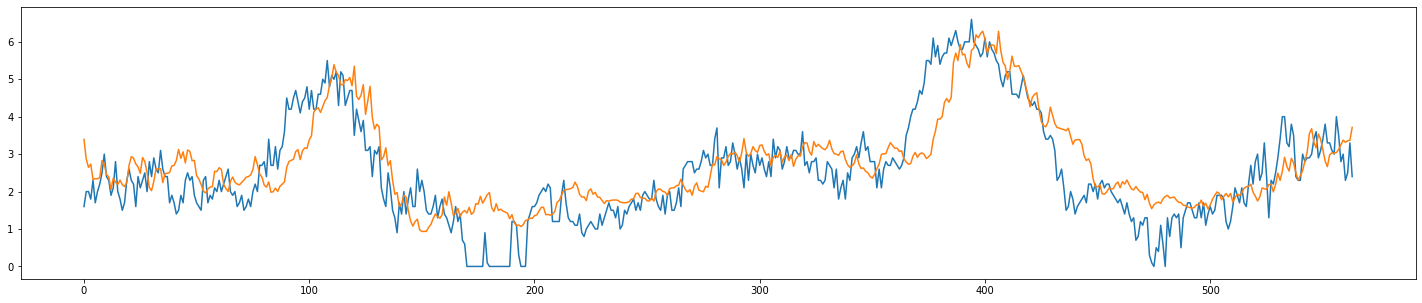

In [157]:
plt.figure(figsize=(25,5))
plt.plot(val['y'].values)
plt.plot(preds);

# plt.plot(val['y'].values - preds);

In [156]:
y_pred_test = model.predict(test.drop('y', axis=1))

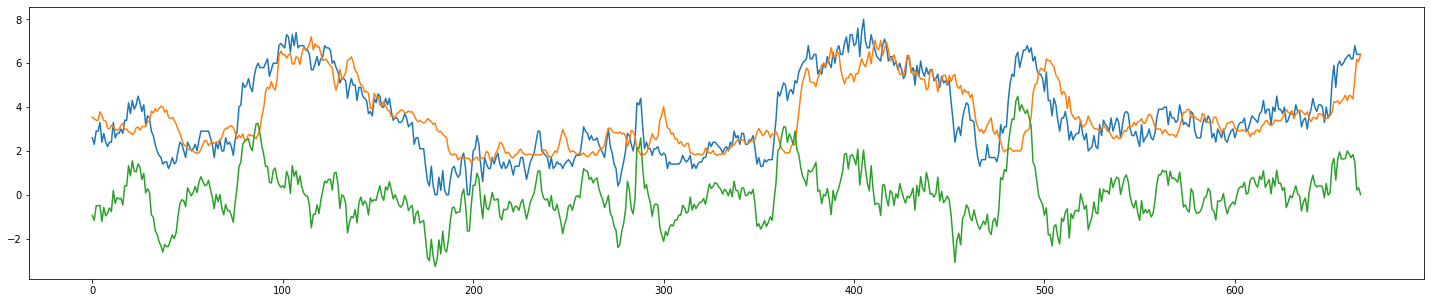

In [158]:
plt.figure(figsize=(25,5))
plt.plot(test['y'].values)
plt.plot(y_pred_test);

plt.plot(test['y'].values - y_pred_test);

In [159]:
mean_absolute_error(test['y'], y_pred_test)

0.8718729497228914

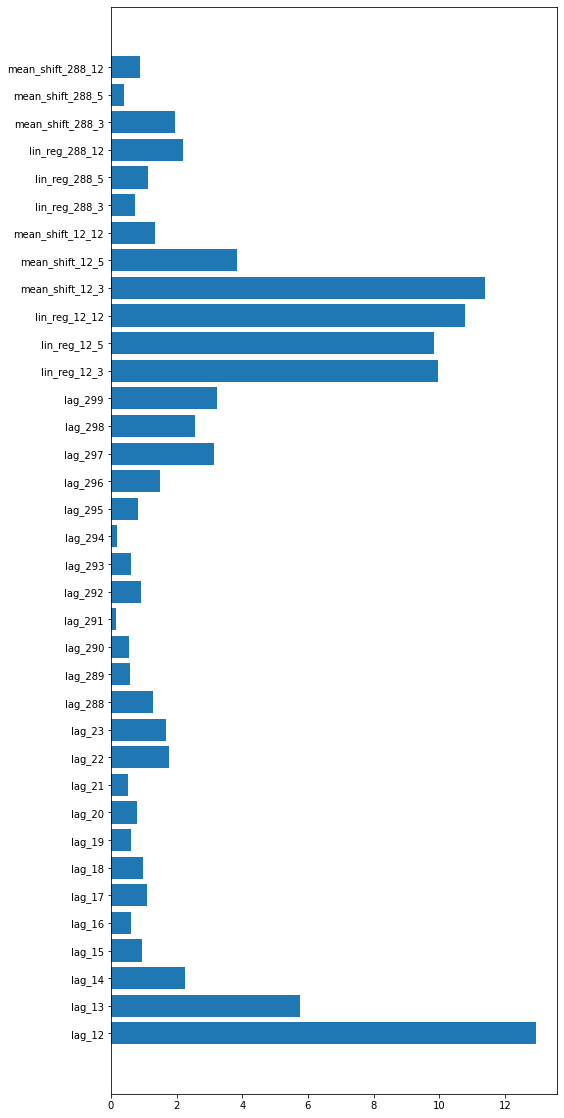

In [160]:
plt.figure(figsize=(8,20))
plt.barh(np.arange(len(model.feature_importances_)), model.feature_importances_)
plt.yticks(np.arange(len(model.feature_importances_)), test.drop('y', axis=1).columns);